In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
import yfinance as yf
import datetime as dt
import warnings
import pypfopt
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import EfficientFrontier
from pypfopt import objective_functions
from pypfopt import CLA
from pypfopt import DiscreteAllocation
from pypfopt import black_litterman
from pypfopt import BlackLittermanModel
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import scipy.optimize as sco
from pypfopt import BlackLittermanModel, plotting
from pypfopt import black_litterman, risk_models
import time
from sklearn.linear_model import Ridge
warnings.filterwarnings('ignore')


# Mean-Variance Optimisation

In [47]:
start = dt.datetime.today() - dt.timedelta(days=5*365)
end = dt.datetime.today()

# get data on this ticker
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'JNJ', 'V', 'JPM', 'PG', 'KO', 'UNH', 'WMT', 'DIS', 'HD', 'NVDA', 'PFE']

# get data on this ticker
ohlc = yf.download(tickers, period="5y", interval="1d")
prices = ohlc["Adj Close"]
prices.tail()

# calculate the covariance matrix using pypfopt
from pypfopt import risk_models
from pypfopt import plotting

sample_cov = risk_models.sample_cov(prices, frequency=252)
sample_cov
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

# Define the stock tickers
stock_tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'JNJ', 'V', 'JPM', 'PG', 'KO', 'UNH', 'WMT', 'DIS', 'HD', 'NVDA', 'PFE']

# Download stock prices
prices = yf.download(stock_tickers, period="5y", interval="1d")["Adj Close"]
prices = pd.DataFrame(prices)

# Create empty dictionaries to store confidence levels
Er_svm = {}
Er_mlp = {}
Er_xgb = {}

# Loop through each stock ticker
for ticker in stock_tickers:
    # Get stock prices and T-bill rates for the specific stock ticker
    ticker_prices = prices[ticker].to_frame()
    ticker_prices["Prediction"] = ticker_prices[ticker].shift(-30)

    # Drop NaN values
    ticker_prices = ticker_prices.dropna()

    # Create X and y datasets
    X = np.array(ticker_prices.drop(["Prediction"], 1))
    y = np.array(ticker_prices["Prediction"])

    # Split the data into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    # SVM Model
    svr = SVR(kernel="rbf", C=1e3, gamma=0.1)
    svr.fit(x_train, y_train)
    svm_confidence = svr.score(x_test, y_test)

    # Neural Network Model
    mlp = MLPRegressor(hidden_layer_sizes=(100, 100, 100), max_iter=1000)
    mlp.fit(x_train, y_train)
    mlp_confidence = mlp.score(x_test, y_test)

    # XGBoost Model
    xgb = XGBRegressor()
    xgb.fit(x_train, y_train)
    xgb_confidence = xgb.score(x_test, y_test)

    # Create the forecast dataset including T-bill rates
    forecast = np.array(ticker_prices.drop(["Prediction"], 1))[-30:]

    # Predict the next 30 days
    svm_prediction = svr.predict(forecast)
    mlp_prediction = mlp.predict(forecast)
    xgb_prediction = xgb.predict(forecast)


    # calculate returns of next 30 days for each stock ticker and appenf to the dictionary
    Er_svm[ticker] = (svm_prediction[-1] - svm_prediction[0]) / svm_prediction[0]
    Er_mlp[ticker] = (mlp_prediction[-1] - mlp_prediction[0]) / mlp_prediction[0]
    Er_xgb[ticker] = (xgb_prediction[-1] - xgb_prediction[0]) / xgb_prediction[0]

# Create a dataframe of the expected returns
Er_svm = pd.DataFrame.from_dict(Er_svm, orient="index", columns=["Expected Return SVM"])
Er_mlp = pd.DataFrame.from_dict(Er_mlp, orient="index", columns=["Expected Return MLP"])
Er_xgb = pd.DataFrame.from_dict(Er_xgb, orient="index", columns=["Expected Return XGB"])
Er = pd.concat([Er_svm, Er_mlp, Er_xgb], axis=1)

print("the expected returns of each stock ticker are: ")
print("\n")
print(Er)

ef = EfficientFrontier(None, S, weight_bounds=(None, None))
ef.min_volatility()
weights = ef.clean_weights()

mvo = ef.portfolio_performance(verbose=True);

# maximising the sharpe Ratio

sector_mapper = {
    "AAPL": "Technology",
    "MSFT": "Technology",
    "AMZN": "Technology",
    "GOOGL": "Technology",
    "JNJ": "Healthcare",
    "V": "Financial Services",
    "JPM": "Financial Services",
    "PG": "Consumer Defensive",
    "KO": "Consumer Defensive",
    "UNH": "Healthcare",
    "WMT": "Consumer Defensive",
    "DIS": "Communication Services",
    "HD": "Consumer Cyclical",
    "NVDA": "Technology",
    "PFE": "Healthcare"
}

sector_lower = {
    "Technology": 0.05,
    "Healthcare": 0.01,
    "Financial Services": 0.01,
    "Consumer Defensive": 0.01,
    "Communication Services": 0.01,
    "Consumer Cyclical": 0.05
}

sector_upper = {
    "Technology": 0.4,
    "Healthcare": 0.3,
    "Financial Services": 0.3,
    "Consumer Defensive": 0.3,
    "Communication Services": 0.3,
    "Consumer Cyclical": 0.3
}

ef = EfficientFrontier(Er["Expected Return SVM"], S)  # weight_bounds automatically set to (0, 1)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)

ef.max_sharpe()
weights_svr = ef.clean_weights()
mvo_svr = ef.portfolio_performance(verbose=True);

ef = EfficientFrontier(Er["Expected Return MLP"], S)  # weight_bounds automatically set to (0, 1)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)

ef.max_sharpe()
weights_mlr = ef.clean_weights()
mvo_mlr = ef.portfolio_performance(verbose=True);

ef = EfficientFrontier(Er["Expected Return XGB"], S)  # weight_bounds automatically set to (0, 1)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)

ef.max_sharpe()
weights_xgb = ef.clean_weights()
mvo_xgb = ef.portfolio_performance(verbose=True);

# combine the weights of the three models into one dataframe
# convert OrderedDict to dataframe
weights_svr = pd.DataFrame.from_dict(weights_svr, orient="index", columns=["SVM"])
weights_mlr = pd.DataFrame.from_dict(weights_mlr, orient="index", columns=["MLP"])
weights_xgb = pd.DataFrame.from_dict(weights_xgb, orient="index", columns=["XGB"])
weights = pd.concat([weights_svr, weights_mlr, weights_xgb], axis=1)
weights.columns = ["SVM", "MLP", "XGB"]
print("weights for each model is:")
print("\n")
print(weights)




[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
the expected returns of each stock ticker are: 


       Expected Return SVM  Expected Return MLP  Expected Return XGB
AAPL              0.036118             0.063990             0.104848
MSFT              0.068835             0.094509             0.082738
AMZN              0.158153             0.141772             0.125163
GOOGL             0.213313             0.130260             0.184046
JNJ              -0.015309            -0.040253            -0.006010
V                 0.011468             0.035610             0.019297
JPM               0.005320             0.093993             0.050226
PG                0.023467             0.008287             0.013758
KO                0.000281            -0.000604            -0.003689
UNH              -0.021748            -0.065460            -0.022213
WMT              -0.019542             0.008266  

# CAPM

Similar to Single Index Model.

Here the Regression equation is:

$$R_{i} = R_{f} + β_{i} (R_{m} - R_{f})$$

We will fit a linear regression for this equation to find $\beta_{i}$
$$R_{i} - R_{f} = β_{i} (R_{m} - R_{f}) + \text{error}$$

Here we are assuming the risk free rate of return($R_{f}$) as 0.01 - T-bill rate

In [144]:
start = dt.datetime.today() - dt.timedelta(days=5*365)
end = dt.datetime.today()

# get data on this ticker
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'JNJ', 'V', 'JPM', 'PG', 'KO', 'UNH', 'WMT', 'DIS', 'HD', 'NVDA', 'PFE']

# get data on this ticker
ohlc = yf.download(tickers, period="5y", interval="1d")
prices = ohlc["Adj Close"]
prices.tail()

# calculate the covariance matrix using pypfopt
from pypfopt import risk_models
from pypfopt import plotting

sample_cov = risk_models.sample_cov(prices, frequency=252)
sample_cov
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

from pypfopt import expected_returns

mu = expected_returns.capm_return(prices)

# Define the stock tickers
stock_tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'JNJ', 'V', 'JPM', 'PG', 'KO', 'UNH', 'WMT', 'DIS', 'HD', 'NVDA', 'PFE']

# Download stock prices
prices = yf.download(stock_tickers, period="5y", interval="1d")["Adj Close"]
prices = pd.DataFrame(prices)

# Download T-bill rates
tbill = yf.download("^IRX", start=prices.index[0], end=prices.index[-1])["Adj Close"]
tbill = tbill / 100

# Create empty dictionaries to store confidence levels
Er_svm = {}
Er_mlp = {}
Er_xgb = {}

# Loop through each stock ticker
for ticker in stock_tickers:
    # Get stock prices and T-bill rates for the specific stock ticker
    ticker_prices = prices[ticker].to_frame()
    ticker_prices["Prediction"] = ticker_prices[ticker].shift(-30)
    ticker_tbill = tbill.copy()

    # Drop NaN values
    ticker_prices = ticker_prices.dropna()
    ticker_tbill = ticker_tbill[ticker_prices.index[0]:ticker_prices.index[-1]]

    # Create X and y datasets
    X = np.array(ticker_prices.drop(["Prediction"], 1))
    X = np.column_stack((X, ticker_tbill.values))  # Add risk-free rate as a factor
    y = np.array(ticker_prices["Prediction"])

    # Split the data into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    # SVM Model
    svr = SVR(kernel="rbf", C=1e3, gamma=0.1)
    svr.fit(x_train, y_train)
    svm_confidence = svr.score(x_test, y_test)

    # Neural Network Model
    mlp = MLPRegressor(hidden_layer_sizes=(100, 100, 100), max_iter=1000)
    mlp.fit(x_train, y_train)
    mlp_confidence = mlp.score(x_test, y_test)

    # XGBoost Model
    xgb = XGBRegressor()
    xgb.fit(x_train, y_train)
    xgb_confidence = xgb.score(x_test, y_test)

    # Create the forecast dataset including T-bill rates
    forecast = np.array(ticker_prices.drop(["Prediction"], 1))[-30:]
    forecast = np.column_stack((forecast, ticker_tbill.values[-30:]))  # Add risk-free rate as a factor

    # Predict the next 30 days
    svm_prediction = svr.predict(forecast)
    mlp_prediction = mlp.predict(forecast)
    xgb_prediction = xgb.predict(forecast)


    # calculate returns of next 30 days for each stock ticker and appenf to the dictionary
    Er_svm[ticker] = (svm_prediction[-1] - svm_prediction[0]) / svm_prediction[0]
    Er_mlp[ticker] = (mlp_prediction[-1] - mlp_prediction[0]) / mlp_prediction[0]
    Er_xgb[ticker] = (xgb_prediction[-1] - xgb_prediction[0]) / xgb_prediction[0]

# Create a dataframe of the expected returns
Er_svm = pd.DataFrame.from_dict(Er_svm, orient="index", columns=["Expected Return SVM"])
Er_mlp = pd.DataFrame.from_dict(Er_mlp, orient="index", columns=["Expected Return MLP"])
Er_xgb = pd.DataFrame.from_dict(Er_xgb, orient="index", columns=["Expected Return XGB"])
Er = pd.concat([Er_svm, Er_mlp, Er_xgb], axis=1)
Er

# CAPM

mu = expected_returns.capm_return(prices)
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

ef = EfficientFrontier(mu, S)
ef.max_sharpe()
weights_CAPM = ef.clean_weights()

CAPM = ef.portfolio_performance(verbose=True);

# SVM

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

ef = EfficientFrontier(Er["Expected Return SVM"], S)
ef.max_sharpe()
weights_svr = ef.clean_weights()

CAPM_svr = ef.portfolio_performance(verbose=True);

# MLP

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

ef = EfficientFrontier(Er["Expected Return MLP"], S)
ef.max_sharpe()
weights_mlr = ef.clean_weights()

CAPM_mlr = ef.portfolio_performance(verbose=True);

# XGB

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
ef = EfficientFrontier(Er["Expected Return XGB"], S)
ef.max_sharpe()
weights_xgb = ef.clean_weights()

CAPM_xgb = ef.portfolio_performance(verbose=True);


weights_svr = pd.DataFrame.from_dict(weights_svr, orient="index", columns=["SVM"])
weights_mlr = pd.DataFrame.from_dict(weights_mlr, orient="index", columns=["MLP"])
weights_xgb = pd.DataFrame.from_dict(weights_xgb, orient="index", columns=["XGB"])
weights = pd.concat([weights_svr, weights_mlr, weights_xgb], axis=1)
weights.columns = ["SVM", "MLP", "XGB"]
print("weights for each model is:")
print("\n")
print(weights)



[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  1 of 1 completed
Expected annual return: 18.5%
Annual volatility: 21.3%
Sharpe Ratio: 0.77
Expected annual return: 12.7%
Annual volatility: 26.7%
Sharpe Ratio: 0.40
Expected annual return: 16.5%
Annual volatility: 27.6%
Sharpe Ratio: 0.53
Expected annual return: 36.9%
Annual volatility: 29.1%
Sharpe Ratio: 1.20
weights for each model is:


           SVM      MLP      XGB
AAPL   0.00000  0.00000  0.00000
MSFT   0.00000  0.00000  0.00000
AMZN   0.47362  0.12709  0.00000
GOOGL  0.44621  0.06623  0.00000
JNJ    0.00000  0.00000  0.00000
V      0.00000  0.00000  0.00000
JPM    0.00000  0.00000  0.00000
PG     0.00000  0.00000  0.00000
KO     0.00000  0.00000  0.00000
UNH    0.00000  0.00000  0.00000
WMT    0.00000  0.00000  0.00000
DIS    0.08017  0.00000  0.00000
HD     0.00000  0.00000  0.00000
NV

# Equity Valuation Model

Equity valuation models are used to estimate the intrinsic value of a company's stock

We are using the Dividend Discount Model (DDM):
The Dividend Discount Model values a stock by calculating the present value of its future expected dividends

The formula for the DDM is:

$V = \frac{D_{1}}{(r - g)}$

Where:

V is the intrinsic value of the stock \\
D_{i} is the expected dividend per share in the next period \\
r is the required rate of return or the discount rate \\
g is the expected growth rate of dividends

- Load dividend values of your stock
- Identify the period of change and only keep unique values in a period
- Train non linear regression model to predict next dividend value
- Calculate average dividend growth rate of your stock
- Assume a discount rate for the stock
- Use ML model to predict next dividend value
- Use the predicted dividend value, discount rate and average dividend growth rate to find stock price

**Note:**

We will use the intrinsic stock value returned by the Equity valuation model as input to the Subjective views dictionary of black litterman model for portfolio allocation.

In [49]:
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'JNJ', 'V', 'JPM', 'PG', 'KO', 'UNH', 'WMT', 'DIS', 'HD', 'NVDA', 'PFE']

# get start and end date 5 years back
end_date = dt.date.today()
start_date = end_date - dt.timedelta(days=5*365)

# get dividend data for each ticker
dividend_data = pd.DataFrame()
for ticker in tickers:
    dividend_data[ticker] = yf.Ticker(ticker).dividends.loc[start_date:end_date].reset_index(drop=True)

# drop columns if NaN
dividend_data.dropna(axis=1, inplace=True)

# multiply by 4 to get annual dividend
dividend_data = dividend_data * 4

# CALCULATE DIVIDEND growth rates
dividend_growth_rates = dividend_data.pct_change().dropna()

avg_dividends_growth_rate = dividend_growth_rates.mask(dividend_growth_rates == 0).sum()/5

print("Dividend Growth rate: \n", avg_dividends_growth_rate)


# create empty dataframe to store next period dividend
next_period_dividend_df = pd.DataFrame()

for ticker in dividend_data.columns:
    X = np.unique(dividend_data[ticker].values)[:-1]
    y = np.unique(dividend_data[ticker].values)[1:]

    # svr nonlinear regression
    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
    svr_rbf.fit(X.reshape(-1, 1), y)
    next_period_dividend_svr = svr_rbf.predict(dividend_data[ticker].values[-1].reshape(1, -1))[0]

    # mlp regression
    mlp = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000)
    mlp.fit(X.reshape(-1, 1), y)
    next_period_dividend_mlp = mlp.predict(dividend_data[ticker].values[-1].reshape(1, -1))[0]

    # xgboost regression
    xgb = XGBRegressor()
    xgb.fit(X.reshape(-1, 1), y)
    next_period_dividend_xgb = xgb.predict(dividend_data[ticker].values[-1].reshape(1, -1))[0]

    # make three different dataframe for each model and make tickers rows and predictied dividend corresponding row values
    next_period_dividend_df[ticker] = [next_period_dividend_svr, next_period_dividend_mlp, next_period_dividend_xgb]

next_period_dividend_df.index = ['svr', 'mlp', 'xgb']

# transpose dataframe to make tickers columns and model corresponding column values
next_period_dividend_df = next_period_dividend_df.T

print("Next period dividend: \n", next_period_dividend_df)

Discount_Rate = {
    "AAPL": 10.8 / 100,
    "MSFT": 10.3 / 100,
    "JNJ": 8.3 / 100,
    "V": 10.5 / 100,
    "JPM": 8.7 / 100,
    "PG": 8.3 / 100,
    "KO": 9.3 / 100,
    "UNH": 8.21 / 100,
    "WMT": 8.5 / 100,
    "HD": 10.3 / 100,
    "NVDA": 12 / 100,
    "PFE": 8.3 / 100,
}

# Get discount rate for each stock from ticker
Discount_Rate = pd.Series(Discount_Rate)

# Calculate the intrinsic value of each stock for each model and make sure to use the correct discount rate for each stock matched by ticker
intrinsic_value_svr = next_period_dividend_df['svr'] / (Discount_Rate - avg_dividends_growth_rate)
intrinsic_value_mlp = next_period_dividend_df['mlp'] / (Discount_Rate - avg_dividends_growth_rate)
intrinsic_value_xgb = next_period_dividend_df['xgb'] / (Discount_Rate - avg_dividends_growth_rate)

# make dataframe for each model and make tickers columns and intrinsic value corresponding column values
intrinsic_value_svr_df = pd.DataFrame(intrinsic_value_svr, columns=['svr'])
intrinsic_value_mlp_df = pd.DataFrame(intrinsic_value_mlp, columns=['mlp'])
intrinsic_value_xgb_df = pd.DataFrame(intrinsic_value_xgb, columns=['xgb'])

# concatenate all three dataframes
intrinsic_value_df = pd.concat([intrinsic_value_svr_df, intrinsic_value_mlp_df, intrinsic_value_xgb_df], axis=1)

print("Intrinsic value: \n", intrinsic_value_df)

# only SVR model is used
viewdict = {
    "AAPL": intrinsic_value_df.loc['AAPL', 'svr']/yf.download("AAPL",period="5y",interval="1d")['Close'].iloc[-1],
    "MSFT": intrinsic_value_df.loc['MSFT', 'svr']/yf.download("MSFT",period="5y",interval="1d")['Close'].iloc[-1],
    "JNJ": intrinsic_value_df.loc['JNJ', 'svr']/yf.download("JNJ",period="5y",interval="1d")['Close'].iloc[-1],
    "V": intrinsic_value_df.loc['V', 'svr']/yf.download("V",period="5y",interval="1d")['Close'].iloc[-1],
    "JPM": intrinsic_value_df.loc['JPM', 'svr']/yf.download("JPM",period="5y",interval="1d")['Close'].iloc[-1],
    "PG": intrinsic_value_df.loc['PG', 'svr']/yf.download("PG",period="5y",interval="1d")['Close'].iloc[-1],
    "KO": intrinsic_value_df.loc['KO', 'svr']/yf.download("KO",period="5y",interval="1d")['Close'].iloc[-1],
    "UNH": intrinsic_value_df.loc['UNH', 'svr']/yf.download("UNH",period="5y",interval="1d")['Close'].iloc[-1],
    "WMT": intrinsic_value_df.loc['WMT', 'svr']/yf.download("WMT",period="5y",interval="1d")['Close'].iloc[-1],
    "HD": intrinsic_value_df.loc['HD', 'svr']/yf.download("HD",period="5y",interval="1d")['Close'].iloc[-1],
    "NVDA": intrinsic_value_df.loc['NVDA', 'svr']/yf.download("NVDA",period="5y",interval="1d")['Close'].iloc[-1],
    "PFE": intrinsic_value_df.loc['PFE', 'svr']/yf.download("PFE",period="5y",interval="1d")['Close'].iloc[-1]
}

# tickers
tickers = list(viewdict.keys())

# market cap
mcaps = {}
for ticker in tickers:
    mcaps[ticker] = yf.Ticker(ticker).info['marketCap']

prices = yf.download(tickers, period="5y", interval="1d")['Close']
S=risk_models.CovarianceShrinkage(prices).ledoit_wolf()
market_prices = yf.download("SPY", period="5y", interval="1d")['Adj Close']

delta = black_litterman.market_implied_risk_aversion(market_prices)

market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)

# Assign confidence measure for stock returns based on some heuristics
confidences = [
    0.6,  # AAPL
    0.4,  # MSFT
    0.3,  # JNJ
    0.5,  # V
    0.3,  # JPM
    0.3,  # PG
    0.3,  # KO
    0.3,  # UNH
    0.3,  # WMT
    0.3,  # HD
    0.3,  # NVDA
    0.3,  # PFE
]

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

ret_bl = bl.bl_returns()

#get covariance matrix
S_bl = bl.bl_cov()

from pypfopt import EfficientFrontier, objective_functions
from pypfopt import DiscreteAllocation

# Efficient Frontier
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights_svr = ef.clean_weights()
ev_svr = ef.portfolio_performance(verbose=True)

# now for MLR model

viewdict = {
    "AAPL": intrinsic_value_df.loc['AAPL', 'mlp']/yf.download("AAPL",period="5y",interval="1d")['Close'].iloc[-1],
    "MSFT": intrinsic_value_df.loc['MSFT', 'mlp']/yf.download("MSFT",period="5y",interval="1d")['Close'].iloc[-1],
    "JNJ": intrinsic_value_df.loc['JNJ', 'mlp']/yf.download("JNJ",period="5y",interval="1d")['Close'].iloc[-1],
    "V": intrinsic_value_df.loc['V', 'mlp']/yf.download("V",period="5y",interval="1d")['Close'].iloc[-1],
    "JPM": intrinsic_value_df.loc['JPM', 'mlp']/yf.download("JPM",period="5y",interval="1d")['Close'].iloc[-1],
    "PG": intrinsic_value_df.loc['PG', 'mlp']/yf.download("PG",period="5y",interval="1d")['Close'].iloc[-1],
    "KO": intrinsic_value_df.loc['KO', 'mlp']/yf.download("KO",period="5y",interval="1d")['Close'].iloc[-1],
    "UNH": intrinsic_value_df.loc['UNH', 'mlp']/yf.download("UNH",period="5y",interval="1d")['Close'].iloc[-1],
    "WMT": intrinsic_value_df.loc['WMT', 'mlp']/yf.download("WMT",period="5y",interval="1d")['Close'].iloc[-1],
    "HD": intrinsic_value_df.loc['HD', 'mlp']/yf.download("HD",period="5y",interval="1d")['Close'].iloc[-1],
    "NVDA": intrinsic_value_df.loc['NVDA', 'mlp']/yf.download("NVDA",period="5y",interval="1d")['Close'].iloc[-1],
    "PFE": intrinsic_value_df.loc['PFE', 'mlp']/yf.download("PFE",period="5y",interval="1d")['Close'].iloc[-1]
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

ret_bl = bl.bl_returns()

#get covariance matrix
S_bl = bl.bl_cov()

from pypfopt import EfficientFrontier, objective_functions
from pypfopt import DiscreteAllocation

# Efficient Frontier
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights_mlr = ef.clean_weights()
ev_mlr = ef.portfolio_performance(verbose=True)


# now for xgboost model

viewdict = {
    "AAPL": intrinsic_value_df.loc['AAPL', 'xgb']/yf.download("AAPL",period="5y",interval="1d")['Close'].iloc[-1],
    "MSFT": intrinsic_value_df.loc['MSFT', 'xgb']/yf.download("MSFT",period="5y",interval="1d")['Close'].iloc[-1],
    "JNJ": intrinsic_value_df.loc['JNJ', 'xgb']/yf.download("JNJ",period="5y",interval="1d")['Close'].iloc[-1],
    "V": intrinsic_value_df.loc['V', 'xgb']/yf.download("V",period="5y",interval="1d")['Close'].iloc[-1],
    "JPM": intrinsic_value_df.loc['JPM', 'xgb']/yf.download("JPM",period="5y",interval="1d")['Close'].iloc[-1],
    "PG": intrinsic_value_df.loc['PG', 'xgb']/yf.download("PG",period="5y",interval="1d")['Close'].iloc[-1],
    "KO": intrinsic_value_df.loc['KO', 'xgb']/yf.download("KO",period="5y",interval="1d")['Close'].iloc[-1],
    "UNH": intrinsic_value_df.loc['UNH', 'xgb']/yf.download("UNH",period="5y",interval="1d")['Close'].iloc[-1],
    "WMT": intrinsic_value_df.loc['WMT', 'xgb']/yf.download("WMT",period="5y",interval="1d")['Close'].iloc[-1],
    "HD": intrinsic_value_df.loc['HD', 'xgb']/yf.download("HD",period="5y",interval="1d")['Close'].iloc[-1],
    "NVDA": intrinsic_value_df.loc['NVDA', 'xgb']/yf.download("NVDA",period="5y",interval="1d")['Close'].iloc[-1],
    "PFE": intrinsic_value_df.loc['PFE', 'xgb']/yf.download("PFE",period="5y",interval="1d")['Close'].iloc[-1]
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

ret_bl = bl.bl_returns()

#get covariance matrix
S_bl = bl.bl_cov()

from pypfopt import EfficientFrontier, objective_functions
from pypfopt import DiscreteAllocation

# Efficient Frontier
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights_xgb = ef.clean_weights()
ev_xgb = ef.portfolio_performance(verbose=True)

weights_svr = pd.DataFrame.from_dict(weights_svr, orient="index", columns=["SVM"])
weights_mlr = pd.DataFrame.from_dict(weights_mlr, orient="index", columns=["MLP"])
weights_xgb = pd.DataFrame.from_dict(weights_xgb, orient="index", columns=["XGB"])
weights = pd.concat([weights_svr, weights_mlr, weights_xgb], axis=1)
weights.columns = ["SVM", "MLP", "XGB"]
print("\n")
print("weights for each model is:")
print("\n")
print(weights)


Dividend Growth rate: 
 AAPL    0.056367
MSFT    0.101178
JNJ     0.057471
V       0.165804
JPM     0.132937
PG      0.056147
KO      0.033621
UNH     0.158946
WMT     0.018531
HD      0.154969
NVDA    0.013333
PFE     0.049351
dtype: float64
Next period dividend: 
            svr        mlp       xgb
AAPL  0.865000   1.007081  0.958892
MSFT  2.810731   3.249566  2.718857
JNJ   4.842605   5.353873  4.758973
V     2.011448   1.859259  1.798972
JPM   4.090577   5.094278  3.998972
PG    3.940906   4.318379  3.762898
KO    1.755919   2.094545  1.838984
UNH   7.744974   9.512714  7.518871
WMT   2.200000   2.510699  2.278871
HD    8.617349  10.572247  8.358815
NVDA  0.160000   0.182991  0.160000
PFE   1.549465   1.789367  1.638986
Intrinsic value: 
               svr          mlp          xgb
AAPL    16.752730    19.504458    18.571159
MSFT  1542.664702  1783.518376  1492.239937
JNJ    189.688101   209.714791   186.412160
V      -33.081091   -30.578126   -29.586614
JPM    -89.048501  -110.89

# Black Litterman Model

[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  1 of 1 completed
2.1476655523666546
AAPL     0.187497
AMZN     0.180428
DIS      0.129860
GOOGL    0.171803
HD       0.130967
JNJ      0.075957
JPM      0.121260
KO       0.080582
MSFT     0.180817
NVDA     0.257522
PFE      0.081296
PG       0.081929
UNH      0.115360
V        0.141219
WMT      0.079137
dtype: float64
AAPL     1.783368
AMZN     2.055050
DIS      0.534324
GOOGL    1.271169
HD       0.723456
JNJ      0.379841
JPM      0.306414
KO       0.188756
MSFT     1.762645
NVDA     5.498174
PFE      0.122204
PG       0.637977
UNH      0.161939
V        0.520746
WMT      3.787612
dtype: float64
Sample portfolio returns: [0.96568152 1.49455414 0.90097974 ... 0.92975494 1.24676449 1.53543593]
Sample portfolio volatilities: 0       0.207583
1       0.203931
2       0.219531
3       0.195667
4  

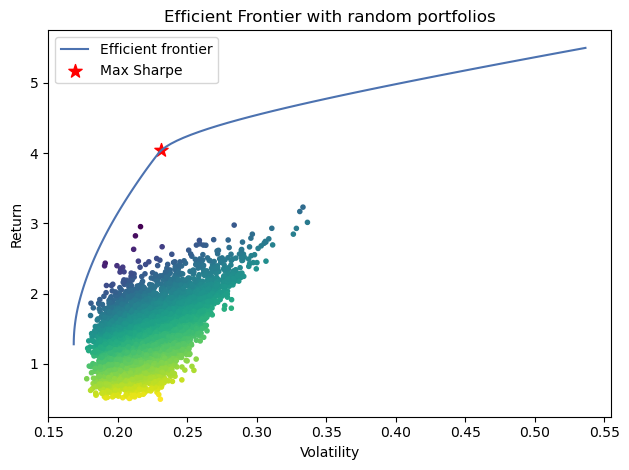

AAPL    -0.064225
AMZN     0.056674
DIS     -0.176712
GOOGL    0.004317
HD       0.056425
JNJ     -0.285518
JPM     -0.086787
KO      -0.227541
MSFT    -0.073581
NVDA     0.271945
PFE     -0.656406
PG      -0.518726
UNH      0.021576
V       -0.115800
WMT     -0.673926
dtype: float64
Expected annual return: 27.2%
Annual volatility: 53.7%
Sharpe Ratio: 0.47
AAPL      6.306954
AMZN     -2.569987
DIS       4.830928
GOOGL     3.646625
HD        5.137920
JNJ      11.505472
JPM       7.637117
KO       29.514108
MSFT      6.736460
NVDA     -2.158816
PFE       3.245289
PG       31.840027
UNH       6.569802
V         8.386930
WMT       4.891832
dtype: float64
Expected annual return: 2963.6%
Annual volatility: 19.4%
Sharpe Ratio: 152.70


In [148]:
# Define the stock tickers
stock_tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'JNJ', 'V', 'JPM', 'PG', 'KO', 'UNH', 'WMT', 'DIS', 'HD', 'NVDA', 'PFE']

# Download stock prices
prices = yf.download(stock_tickers, period="5y", interval="1d")["Adj Close"].pct_change().dropna()
prices = pd.DataFrame(prices)

# Create empty dictionaries to store confidence levels
Er_svm = {}
Er_mlp = {}
Er_xgb = {}

# Loop through each stock ticker
for ticker in stock_tickers:
    # Get stock prices and T-bill rates for the specific stock ticker
    ticker_prices = prices[ticker].to_frame()
    ticker_prices["Prediction"] = ticker_prices[ticker].shift(-30)

    # Drop NaN values
    ticker_prices = ticker_prices.dropna()

    # Create X and y datasets
    X = np.array(ticker_prices.drop(["Prediction"], 1))
    y = np.array(ticker_prices["Prediction"])

    # Split the data into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    # SVM Model
    svr = SVR(kernel="rbf", C=1e3, gamma=0.1)
    svr.fit(x_train, y_train)
    svm_confidence = svr.score(x_test, y_test)

    # Neural Network Model
    mlp = MLPRegressor(hidden_layer_sizes=(100, 100, 100), max_iter=1000)
    mlp.fit(x_train, y_train)
    mlp_confidence = mlp.score(x_test, y_test)

    # XGBoost Model
    xgb = XGBRegressor()
    xgb.fit(x_train, y_train)
    xgb_confidence = xgb.score(x_test, y_test)

    
    forecast = np.array(ticker_prices.drop(["Prediction"], 1))[-30:]

    # Predict the next 30 days
    svm_prediction = svr.predict(forecast)
    mlp_prediction = mlp.predict(forecast)
    xgb_prediction = xgb.predict(forecast)


    # calculate returns of next 30 days for each stock ticker and appenf to the dictionary
    Er_svm[ticker] = (svm_prediction[-1] - svm_prediction[0]) / svm_prediction[0]
    Er_mlp[ticker] = (mlp_prediction[-1] - mlp_prediction[0]) / mlp_prediction[0]
    Er_xgb[ticker] = (xgb_prediction[-1] - xgb_prediction[0]) / xgb_prediction[0]

# Create a dataframe of the expected returns
Er_svm = pd.DataFrame.from_dict(Er_svm, orient="index", columns=["Expected Return SVM"])
Er_mlp = pd.DataFrame.from_dict(Er_mlp, orient="index", columns=["Expected Return MLP"])
Er_xgb = pd.DataFrame.from_dict(Er_xgb, orient="index", columns=["Expected Return XGB"])
Er = pd.concat([Er_svm, Er_mlp, Er_xgb], axis=1)
Er

viewdict = {
    "AAPL": Er.loc['AAPL', 'Expected Return SVM'],
    "MSFT": Er.loc['MSFT', 'Expected Return SVM'],
    "AMZN": Er.loc['AMZN', 'Expected Return SVM'],
    "GOOGL": Er.loc['GOOGL', 'Expected Return SVM'],
    "JNJ": Er.loc['JNJ', 'Expected Return SVM'],
    "V": Er.loc['V', 'Expected Return SVM'],
    "JPM": Er.loc['JPM', 'Expected Return SVM'],
    "PG": Er.loc['PG', 'Expected Return SVM'],
    "KO": Er.loc['KO', 'Expected Return SVM'],
    "UNH": Er.loc['UNH', 'Expected Return SVM'],
    "WMT": Er.loc['WMT', 'Expected Return SVM'],
    "DIS": Er.loc['DIS', 'Expected Return SVM'],
    "HD": Er.loc['HD', 'Expected Return SVM'],
    "NVDA": Er.loc['NVDA', 'Expected Return SVM'],
    "PFE": Er.loc['PFE', 'Expected Return SVM']
}

mcaps = {}
for ticker in stock_tickers:
    mcaps[ticker] = yf.Ticker(ticker).info['marketCap']

prices = yf.download(stock_tickers, period="5y", interval="1d")["Adj Close"]
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
market_prices = yf.download("^GSPC", period="5y", interval="1d")["Adj Close"]

delta = black_litterman.market_implied_risk_aversion(market_prices)
print(delta)
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
print(market_prior)

# 15 confidence levels for each stock ticker
confidences = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]

# fit BL model
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

# get the posterior estimate of returns
ret_bl = bl.bl_returns()
print(ret_bl)

# get the posterior estimate of the covariance matrix
S_bl = bl.bl_cov()

# get the posterior estimate of the tangency portfolio
ef = EfficientFrontier(ret_bl, S_bl)
# ef.add_objective(objective_functions.L2_reg, gamma=0.1)
# weights = ef.max_sharpe()
# cleaned_weights_svr = ef.clean_weights()
# bl_svr = ef.portfolio_performance(verbose=True)

n_samples = 10000
w = np.random.dirichlet(np.ones(len(ret_bl)), n_samples)
rets = w.dot(ret_bl)
stds = np.sqrt((w.T * (S_bl @ w.T)).sum(axis=0))
sharpes = rets / stds

print("Sample portfolio returns:", rets)
print("Sample portfolio volatilities:", stds)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(ret_bl, S_bl)
ef2.max_sharpe()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()


# mlr
viewdict = {
    "AAPL": Er.loc['AAPL', 'Expected Return MLP'],
    "MSFT": Er.loc['MSFT', 'Expected Return MLP'],
    "AMZN": Er.loc['AMZN', 'Expected Return MLP'],
    "GOOGL": Er.loc['GOOGL', 'Expected Return MLP'],
    "JNJ": Er.loc['JNJ', 'Expected Return MLP'],
    "V": Er.loc['V', 'Expected Return MLP'],
    "JPM": Er.loc['JPM', 'Expected Return MLP'],
    "PG": Er.loc['PG', 'Expected Return MLP'],
    "KO": Er.loc['KO', 'Expected Return MLP'],
    "UNH": Er.loc['UNH', 'Expected Return MLP'],
    "WMT": Er.loc['WMT', 'Expected Return MLP'],
    "DIS": Er.loc['DIS', 'Expected Return MLP'],
    "HD": Er.loc['HD', 'Expected Return MLP'],
    "NVDA": Er.loc['NVDA', 'Expected Return MLP'],
    "PFE": Er.loc['PFE', 'Expected Return MLP']
}

# fit BL model
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

# get the posterior estimate of returns
ret_bl = bl.bl_returns()
print(ret_bl)

# get the posterior estimate of the covariance matrix
S_bl = bl.bl_cov()

# get the posterior estimate of the tangency portfolio
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
weights = ef.max_sharpe()
cleaned_weights_mlp = ef.clean_weights()
bl_mlr = ef.portfolio_performance(verbose=True)

# xgb
viewdict = {
    "AAPL": Er.loc['AAPL', 'Expected Return XGB'],
    "MSFT": Er.loc['MSFT', 'Expected Return XGB'],
    "AMZN": Er.loc['AMZN', 'Expected Return XGB'],
    "GOOGL": Er.loc['GOOGL', 'Expected Return XGB'],
    "JNJ": Er.loc['JNJ', 'Expected Return XGB'],
    "V": Er.loc['V', 'Expected Return XGB'],
    "JPM": Er.loc['JPM', 'Expected Return XGB'],
    "PG": Er.loc['PG', 'Expected Return XGB'],
    "KO": Er.loc['KO', 'Expected Return XGB'],
    "UNH": Er.loc['UNH', 'Expected Return XGB'],
    "WMT": Er.loc['WMT', 'Expected Return XGB'],
    "DIS": Er.loc['DIS', 'Expected Return XGB'],
    "HD": Er.loc['HD', 'Expected Return XGB'],
    "NVDA": Er.loc['NVDA', 'Expected Return XGB'],
    "PFE": Er.loc['PFE', 'Expected Return XGB']
}

# fit BL model
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

# get the posterior estimate of returns
ret_bl = bl.bl_returns()
print(ret_bl)

# get the posterior estimate of the covariance matrix
S_bl = bl.bl_cov()

# get the posterior estimate of the tangency portfolio
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
weights = ef.max_sharpe()
cleaned_weights_xgb = ef.clean_weights()
bl_xgb = ef.portfolio_performance(verbose=True)


# Best Sharpe Ratio and portfolio

In [140]:
# Create a dataframe with all sharpe ratios and portfolio returns and volatility for each model
models = ["mvo_svr","mvo_mlr","mvo_xgb","bl_svr","bl_mlr","bl_xgb","CAPM","CAPM_svr","CAPM_mlr","CAPM_xgb","ev_svr","ev_mlr","ev_xgb"]

# Create a dataframe with all sharpe ratios and portfolio returns and volatility for each model
models = ["mvo_svr","mvo_mlr","mvo_xgb","bl_svr","bl_mlr","bl_xgb","CAPM","CAPM_svr","CAPM_mlr","CAPM_xgb","ev_svr","ev_mlr","ev_xgb"]
sharpe_ratios = [mvo_svr[2],mvo_mlr[2],mvo_xgb[2],bl_svr[2],bl_mlr[2],bl_xgb[2],CAPM[2],CAPM_svr[2],CAPM_mlr[2],CAPM_xgb[2],ev_svr[2],ev_mlr[2],ev_xgb[2]]
returns = [mvo_svr[0],mvo_mlr[0],mvo_xgb[0],bl_svr[0],bl_mlr[0],bl_xgb[0],CAPM[0],CAPM_svr[0],CAPM_mlr[0],CAPM_xgb[0],ev_svr[0],ev_mlr[0],ev_xgb[0]]
volatility = [mvo_svr[1],mvo_mlr[1],mvo_xgb[1],bl_svr[1],bl_mlr[1],bl_xgb[1],CAPM[1],CAPM_svr[1],CAPM_mlr[1],CAPM_xgb[1],ev_svr[1],ev_mlr[1],ev_xgb[1]]
df = pd.DataFrame(list(zip(models, sharpe_ratios, returns, volatility)), columns =['Model', 'Sharpe Ratio', 'Returns', 'Volatility'])
df
# arrange the columns in decending order of Sharpe Ratio
df = df.sort_values(by=['Sharpe Ratio'], ascending=False)
print(df)

cleaned_weights_svr

# rebalance portfolio weights
# get the discrete allocation of each share per stock
latest_prices = prices.iloc[-1] # latest prices
weights = cleaned_weights_svr
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=800000)
allocation, leftover = da.lp_portfolio()
print('Discrete allocation:', allocation)
print('Funds remaining: ${:.2f}'.format(leftover))


       Model  Sharpe Ratio   Returns  Volatility
3     bl_svr     15.714225  4.124398    0.261190
5     bl_xgb      8.487120  1.968414    0.229573
11    ev_mlr      3.579410  0.836043    0.227983
10    ev_svr      3.132093  0.731575    0.227188
12    ev_xgb      3.080552  0.715965    0.225922
4     bl_mlr      2.150547  0.837871    0.380308
9   CAPM_xgb      1.169042  0.360437    0.291210
6       CAPM      0.786585  0.187561    0.213024
2    mvo_xgb      0.588676  0.134224    0.194036
8   CAPM_mlr      0.535519  0.166779    0.274088
7   CAPM_svr      0.515706  0.168512    0.287979
0    mvo_svr      0.467646  0.116042    0.205373
1    mvo_mlr      0.336354  0.098804    0.234288
Discrete allocation: {'AMZN': 29, 'NVDA': 588, 'WMT': 3453}
Funds remaining: $106.66


# Algorithmic Trading

In [141]:

import time
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from alpha_vantage.timeseries import TimeSeries

# Define the stock tickers
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'JNJ', 'V', 'JPM', 'PG', 'KO', 'UNH', 'WMT', 'DIS', 'HD', 'NVDA', 'PFE']

# # Set up AlphaVantage API credentials
# api_key = 'GFDF5G84A1QEWW9M'
# ts = TimeSeries(key=api_key, output_format='pandas')

# Define the initial capital and number of shares per stock
initial_capital = 150000
num_shares = initial_capital / len(tickers)

portfolio = {}

# Iterate over each stock ticker

# Iterate over each stock ticker
for ticker in tickers:
    # Get the data for the stock
    data = yf.download(ticker, period='5y', interval='1d')
    data = pd.DataFrame(data["Adj Close"])
    data["prediction"] = data.shift(-1)
    data = data.dropna()

    X = np.array(data.drop(["prediction"], 1))
    y = np.array(data["prediction"])

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    # Train the models
    svr = SVR()
    svr.fit(X_train, y_train)

    mlr = LinearRegression()
    mlr.fit(X_train, y_train)

    xgr = XGBRegressor()
    xgr.fit(X_train, y_train)

    # Get the latest price and make predictions
    latest_price = data["Adj Close"][-1]
    forecast = np.array(data.drop(["prediction"], 1))[-1:]

    svr_prediction = svr.predict(forecast)
    mlr_prediction = mlr.predict(forecast)
    xgr_prediction = xgr.predict(forecast)

    # Choose the model with the best accuracy value
    predictions = [svr_prediction, mlr_prediction, xgr_prediction]
    best_prediction = np.argmax(predictions)

        # Calculate the number of shares to buy/sell
    if best_prediction == 0:  # SVR
        if svr_prediction > latest_price:
            shares_to_buy = int(num_shares / latest_price)
            portfolio[ticker] = shares_to_buy
        elif svr_prediction < latest_price:
            shares_to_sell = int(num_shares / latest_price)
            portfolio[ticker] = -shares_to_sell
        else:
            portfolio[ticker] = 0
    elif best_prediction == 1:  # MLR
        if mlr_prediction > latest_price:
            shares_to_buy = int(num_shares / latest_price)
            portfolio[ticker] = shares_to_buy
        elif mlr_prediction < latest_price:
            shares_to_sell = int(num_shares / latest_price)
            portfolio[ticker] = -shares_to_sell
        else:
            portfolio[ticker] = 0
    else:
        if xgr_prediction > latest_price:
            shares_to_buy = int(num_shares / latest_price)
            portfolio[ticker] = shares_to_buy
        elif xgr_prediction < latest_price:
            shares_to_sell = int(num_shares / latest_price)
            portfolio[ticker] = -shares_to_sell
        else:
            portfolio[ticker] = 0

# Print the portfolio
print("Portfolio:")
for ticker, shares in portfolio.items():
    print(ticker, "-", shares, "shares")

# Calculate the portfolio value
portfolio_value = 0
for ticker, shares in portfolio.items():
    latest_price = yf.download(ticker, period='1d', interval='1d')["Adj Close"][-1]
    stock_value = shares * latest_price
    portfolio_value += stock_value

print("Portfolio Value:", portfolio_value)




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

4455.58984375